Project 3: Unsupervised Learning

tpham328

Exploration 4 and 5: Neural Network on Wine Dataset

In [97]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import time

from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from scipy import stats
from sklearn.metrics import mean_squared_error, homogeneity_score, completeness_score, adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples

from warnings import filterwarnings
filterwarnings(action='ignore')

In [98]:
data = pd.read_csv("winequality-white.csv")
print("Successfully Imported Data!")

data.head()
print(data.shape)

Successfully Imported Data!
(4898, 12)


In [99]:
data.describe(include='all')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


<Axes: >

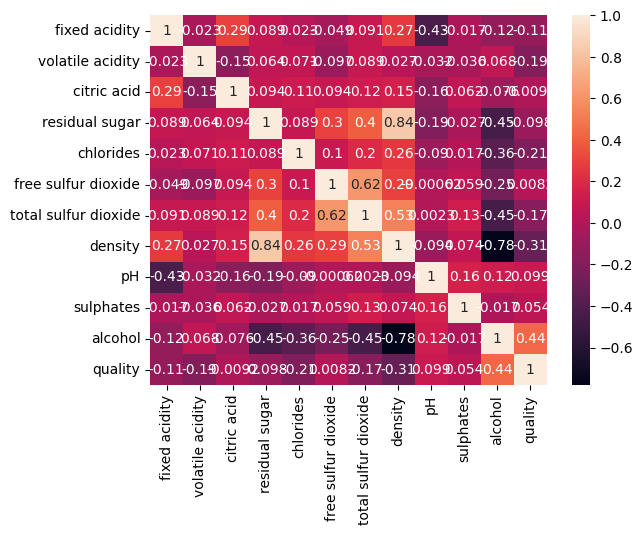

In [100]:
corr = data.corr()
sns.heatmap(corr,annot=True)

In [101]:


# Assuming 'data' is your dataframe and 'quality' is the label column
X = data.drop(columns='quality')
original_Y = data['quality']

def class_quality(value):
    if value <= 5:
        return 0
    elif value == 6:
        return 1
    elif value >= 7:
        return 2
Y = original_Y.apply(class_quality)

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [102]:
# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=328)
print(X_train.shape[0])
print(X_test.shape[0])

3918
980


In [103]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import validation_curve, learning_curve, GridSearchCV, cross_val_score
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from sklearn.model_selection import StratifiedKFold

# Using NN on PCA dataset

In [104]:
# Apply PCA with 8 components on the training data
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)

# Transform the test set using the same PCA
X_test_pca = pca.transform(X_test)


In [105]:
# FINDING OPTIMAL HYPERPARAMETERS 

class Net(nn.Module):
    def __init__(self, num_layers=2, hidden_units=100, activation='relu'):
        super(Net, self).__init__()
        layers = []
        input_size = 8  

        # Choose the activation function
        if activation == 'relu':
            activation_function = nn.ReLU()
        elif activation == 'sigmoid':
            activation_function = nn.Sigmoid()
        
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(activation_function)
            input_size = hidden_units
        layers.append(nn.Linear(hidden_units, 3))  # Assuming 10 output classes for classification
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

# Define objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    num_layers = trial.suggest_int('num_layers', 2, 10)
    hidden_units = trial.suggest_int('hidden_units', 10, 256)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid'])

    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Split the data into training and validation sets
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_pca, Y_train, test_size=0.2, random_state=328)
    X_train_split = X_train_split if isinstance(X_train_split, np.ndarray) else X_train_split.to_numpy()
    X_val = X_val if isinstance(X_val, np.ndarray) else X_val.to_numpy()
    y_train_split = y_train_split if isinstance(y_train_split, np.ndarray) else y_train_split.to_numpy()
    y_val = y_val if isinstance(y_val, np.ndarray) else y_val.to_numpy()

    # Convert to torch tensors
    X_train_split = torch.tensor(X_train_split, dtype=torch.float32)
    y_train_split = torch.tensor(y_train_split, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_split)
        loss = criterion(output, y_train_split)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_pred = val_output.argmax(dim=1, keepdim=True)
        accuracy = accuracy_score(y_val, val_pred)

    return accuracy


# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best parameters found: ", study.best_params)
print("Best cross-validation accuracy: {:.2f}".format(study.best_value))

# Use the best model parameters
best_params = study.best_params
best_model = Net(num_layers=best_params['num_layers'], hidden_units=best_params['hidden_units'], activation=best_params['activation'])
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])

print("X Shape",X_train.shape)
print("Y Shape",Y_train.shape)


[I 2024-07-16 17:18:07,291] A new study created in memory with name: no-name-817d95d3-cee7-43bc-8c25-228b21d6d0b0
[I 2024-07-16 17:18:07,565] Trial 0 finished with value: 0.45663265306122447 and parameters: {'lr': 0.013153738440484413, 'num_layers': 6, 'hidden_units': 238, 'activation': 'relu'}. Best is trial 0 with value: 0.45663265306122447.
[I 2024-07-16 17:18:07,601] Trial 1 finished with value: 0.4413265306122449 and parameters: {'lr': 0.007573077439417927, 'num_layers': 3, 'hidden_units': 24, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.45663265306122447.
[I 2024-07-16 17:18:07,967] Trial 2 finished with value: 0.4413265306122449 and parameters: {'lr': 0.001080125934983634, 'num_layers': 7, 'hidden_units': 251, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.45663265306122447.
[I 2024-07-16 17:18:08,019] Trial 3 finished with value: 0.4413265306122449 and parameters: {'lr': 0.004780881834561568, 'num_layers': 3, 'hidden_units': 95, 'activation': 'sigmoid'}. Bes

Best parameters found:  {'lr': 0.0013337393259685464, 'num_layers': 2, 'hidden_units': 221, 'activation': 'relu'}
Best cross-validation accuracy: 0.57
X Shape (3918, 11)
Y Shape (3918,)


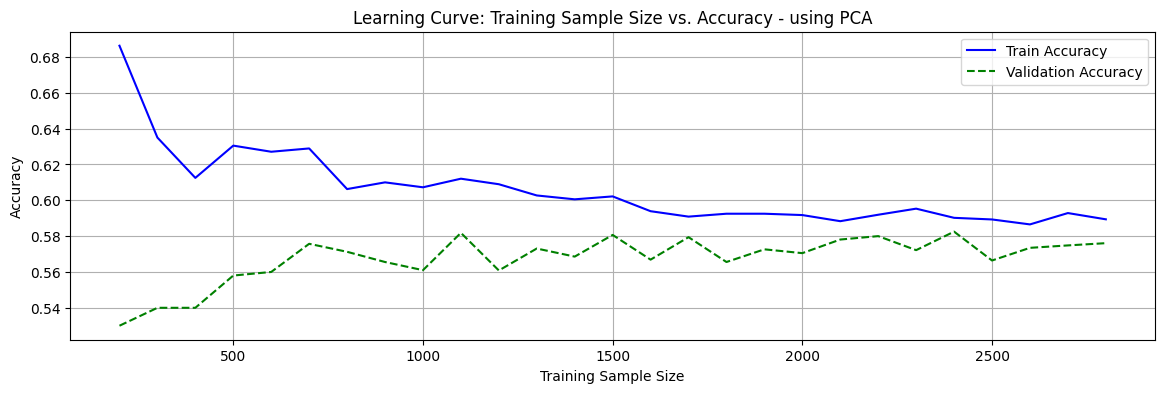

In [106]:
# LEARNING CURVE - on sample size


# Function to train and evaluate the model
def train_and_evaluate(X, y, train_size, lr=0.003, num_layers=2, hidden_units=200, activation='relu', cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=328)
    train_accuracies = []
    val_accuracies = []
    X_sample = X[:train_size]
    Y_sample = y[:train_size]
    for train_index, val_index in skf.split(X_sample, Y_sample):
        X_train_fold, X_val_fold = X_sample[train_index], X_sample[val_index]
        y_train_fold, y_val_fold = Y_sample[train_index], Y_sample[val_index]

        # Convert to torch tensors
        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.long)
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.long)


        # Create the model
        model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_fold)
            loss = criterion(output, y_train_fold)
            loss.backward()
            optimizer.step()

        # Evaluation on training set
        model.eval()
        with torch.no_grad():
            train_output = model(X_train_fold)
            train_pred = train_output.argmax(dim=1, keepdim=True)
            train_accuracy = accuracy_score(y_train_fold, train_pred)
            train_accuracies.append(train_accuracy)

            val_output = model(X_val_fold)
            val_pred = val_output.argmax(dim=1, keepdim=True)
            val_accuracy = accuracy_score(y_val_fold, val_pred)
            val_accuracies.append(val_accuracy)

    return np.mean(train_accuracies), np.mean(val_accuracies)

# Main script
train_sizes = np.arange(200, 2900, 100)
train_accuracies = []
val_accuracies = []

X_train_pca = X_train_pca if isinstance(X_train_pca, np.ndarray) else X_train_pca.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# print(X_train)
for train_size in train_sizes:
    train_acc, val_acc = train_and_evaluate(X_train_pca, Y_train, train_size=train_size)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Plotting the learning curve
plt.figure(figsize=(14, 4))
plt.plot(train_sizes, train_accuracies, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(train_sizes, val_accuracies, label='Validation Accuracy', color='green', linestyle='--')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Training Sample Size vs. Accuracy - using PCA')
plt.legend()
plt.grid(True)
plt.show()

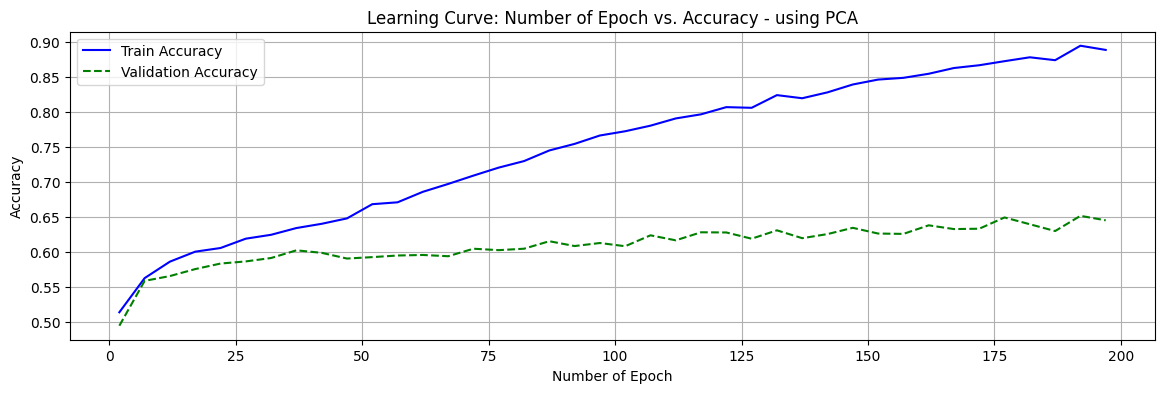

In [107]:
# LEARNING CURVE - on epochs


# Function to train and evaluate the model
def train_and_evaluate(X, y, num_epochs, lr=0.003, num_layers=2, hidden_units=200, activation='relu', cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=328)
    train_accuracies = []
    val_accuracies = []

    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Convert to torch tensors
        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.long)
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.long)


        # Create the model
        model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_fold)
            loss = criterion(output, y_train_fold)
            loss.backward()
            optimizer.step()

        # Evaluation on training set
        model.eval()
        with torch.no_grad():
            train_output = model(X_train_fold)
            train_pred = train_output.argmax(dim=1, keepdim=True)
            train_accuracy = accuracy_score(y_train_fold, train_pred)
            train_accuracies.append(train_accuracy)

            val_output = model(X_val_fold)
            val_pred = val_output.argmax(dim=1, keepdim=True)
            val_accuracy = accuracy_score(y_val_fold, val_pred)
            val_accuracies.append(val_accuracy)

    return np.mean(train_accuracies), np.mean(val_accuracies)

# Main script
num_epochs = np.arange(2, 200, 5)
train_accuracies = []
val_accuracies = []

X_train_pca = X_train_pca if isinstance(X_train_pca, np.ndarray) else X_train_pca.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# ADD TRAIN TIME
pca_times = []
start_time = time.time()

# print(X_train)
for epoch in num_epochs:
    # print("EPOCH",epoch)

    train_acc, val_acc = train_and_evaluate(X_train_pca, Y_train, epoch)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    pca_times.append(time.time() - start_time)

# Plotting the learning curve
plt.figure(figsize=(14, 4))
plt.plot(num_epochs, train_accuracies, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(num_epochs, val_accuracies, label='Validation Accuracy', color='green', linestyle='--')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Number of Epoch vs. Accuracy - using PCA')
plt.legend()
plt.grid(True)
plt.show()

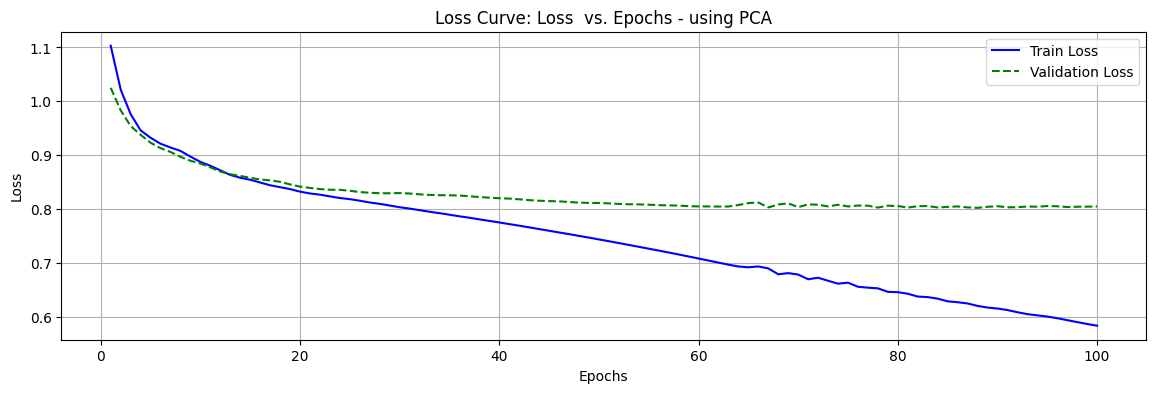

In [109]:
#LOSS CURVE



# Function to train and evaluate the model
def train_and_evaluate(X_train, Y_train, X_Test, Y_test, epochs, lr=0.003, num_layers=2, hidden_units=200, activation='relu'):
    train_losses = []
    val_losses = []

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.long)
    X_Test = torch.tensor(X_Test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.long)


    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, Y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Evaluation on validation set
        model.eval()
        with torch.no_grad():
            val_output = model(X_Test)
            val_loss = criterion(val_output, Y_test)
            val_losses.append(val_loss.item())

    return train_losses, val_losses

# Main script
epochs = 100
train_losses = []
val_losses = []

X_test_pca = X_test_pca if isinstance(X_test_pca, np.ndarray) else X_test_pca.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()
train_losses, val_losses = train_and_evaluate(X_train_pca, Y_train, X_test_pca, Y_test, epochs)

# Plotting the loss curve
plt.figure(figsize=(14, 4))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue', linestyle='-')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='green', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve: Loss  vs. Epochs - using PCA')
plt.legend()
plt.grid(True)
plt.show()



In [110]:
import random
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Function to train the model
def train_model(X_train, y_train, epochs=20, lr=0.003, num_layers=2, hidden_units=200, activation='relu',seed = 390):
    
    set_seed(seed)

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)

    # Determine input size from X_train
    input_size = X_train.shape[1]
    print(X_train.shape[1])
    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    return model


epochs = 30
lr = 0.003
num_layers = 2
hidden_units = 200
activation = 'relu'


Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()

# Train the model
model = train_model(X_train_pca, Y_train, epochs, lr, num_layers, hidden_units, activation)

# Convert the test data to torch tensors
X_test_pca = torch.tensor(X_test_pca, dtype=torch.float32)

# Make predictions on the test data
model.eval()
with torch.no_grad():
    output = model(X_test_pca)
    y_pred = output.argmax(dim=1, keepdim=True).numpy()

# Evaluate the model
print("Classification Report NN:")
print(classification_report(Y_test, y_pred))
print("Accuracy Score: ", accuracy_score(Y_test, y_pred))

8
Classification Report NN:
              precision    recall  f1-score   support

           0       0.64      0.67      0.65       304
           1       0.58      0.66      0.62       450
           2       0.64      0.42      0.51       226

    accuracy                           0.61       980
   macro avg       0.62      0.58      0.59       980
weighted avg       0.61      0.61      0.60       980

Accuracy Score:  0.6071428571428571


# Neural Network with ICA

In [111]:
# Apply ICA with 7 components
ica = FastICA(n_components=7, random_state=328)
X_train_ica = ica.fit_transform(X_train)

# Only fit ICA on the training data, and transform the test data without fitting again to prevent data leakage
X_test_ica = ica.transform(X_test)
print(X_train_ica.shape[0])
print(X_test_ica.shape[0])

3918
980


In [112]:
# FINDING OPTIMAL HYPERPARAMETERS 

class Net(nn.Module):
    def __init__(self, num_layers=2, hidden_units=100, activation='relu'):
        super(Net, self).__init__()
        layers = []
        input_size = 7

        # Choose the activation function
        if activation == 'relu':
            activation_function = nn.ReLU()
        elif activation == 'sigmoid':
            activation_function = nn.Sigmoid()
        
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(activation_function)
            input_size = hidden_units
        layers.append(nn.Linear(hidden_units, 3))  # Assuming 10 output classes for classification
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

# Define objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    num_layers = trial.suggest_int('num_layers', 2, 10)
    hidden_units = trial.suggest_int('hidden_units', 10, 256)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid'])

    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Split the data into training and validation sets
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_ica, Y_train, test_size=0.2, random_state=328)
    X_train_split = X_train_split if isinstance(X_train_split, np.ndarray) else X_train_split.to_numpy()
    X_val = X_val if isinstance(X_val, np.ndarray) else X_val.to_numpy()
    y_train_split = y_train_split if isinstance(y_train_split, np.ndarray) else y_train_split.to_numpy()
    y_val = y_val if isinstance(y_val, np.ndarray) else y_val.to_numpy()

    # Convert to torch tensors
    X_train_split = torch.tensor(X_train_split, dtype=torch.float32)
    y_train_split = torch.tensor(y_train_split, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_split)
        loss = criterion(output, y_train_split)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_pred = val_output.argmax(dim=1, keepdim=True)
        accuracy = accuracy_score(y_val, val_pred)

    return accuracy


# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best parameters found: ", study.best_params)
print("Best cross-validation accuracy: {:.2f}".format(study.best_value))

# Use the best model parameters
best_params = study.best_params
best_model = Net(num_layers=best_params['num_layers'], hidden_units=best_params['hidden_units'], activation=best_params['activation'])
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])

print("X Shape",X_train.shape)
print("Y Shape",Y_train.shape)


[I 2024-07-16 17:20:50,736] A new study created in memory with name: no-name-f3e4a4b8-28e2-4701-90f9-471b144ef35d
[I 2024-07-16 17:20:51,130] Trial 0 finished with value: 0.4413265306122449 and parameters: {'lr': 0.00016006977641607235, 'num_layers': 8, 'hidden_units': 193, 'activation': 'relu'}. Best is trial 0 with value: 0.4413265306122449.
[I 2024-07-16 17:20:51,181] Trial 1 finished with value: 0.5204081632653061 and parameters: {'lr': 0.0016228185823741153, 'num_layers': 2, 'hidden_units': 108, 'activation': 'relu'}. Best is trial 1 with value: 0.5204081632653061.
[I 2024-07-16 17:20:51,214] Trial 2 finished with value: 0.3711734693877551 and parameters: {'lr': 0.0001883156050078058, 'num_layers': 2, 'hidden_units': 63, 'activation': 'relu'}. Best is trial 1 with value: 0.5204081632653061.
[I 2024-07-16 17:20:51,528] Trial 3 finished with value: 0.4413265306122449 and parameters: {'lr': 0.013817015871835822, 'num_layers': 10, 'hidden_units': 188, 'activation': 'sigmoid'}. Best is

Best parameters found:  {'lr': 0.0019238599614974949, 'num_layers': 3, 'hidden_units': 244, 'activation': 'relu'}
Best cross-validation accuracy: 0.59
X Shape (3918, 11)
Y Shape (3918,)


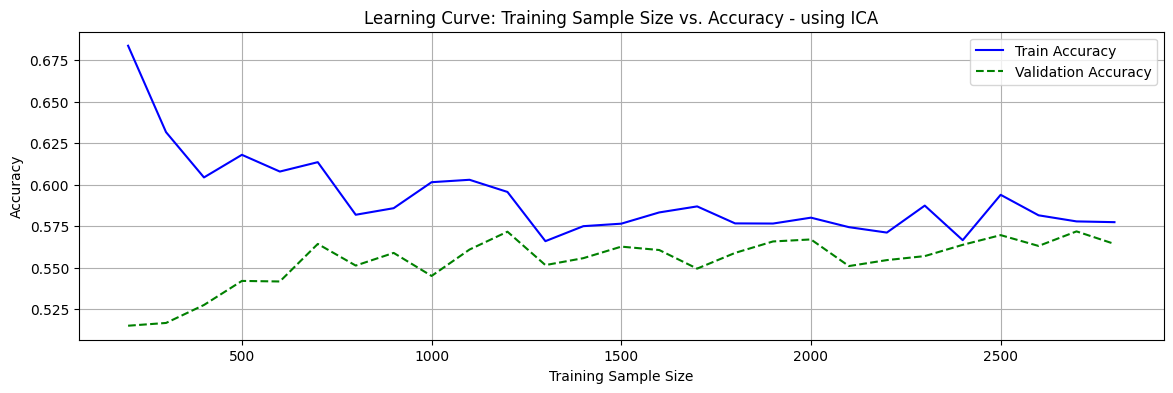

In [113]:
# LEARNING CURVE - on sample size


# Function to train and evaluate the model
def train_and_evaluate(X, y, train_size, lr=0.01, num_layers=2, hidden_units=200, activation='relu', cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=328)
    train_accuracies = []
    val_accuracies = []
    X_sample = X[:train_size]
    Y_sample = y[:train_size]
    for train_index, val_index in skf.split(X_sample, Y_sample):
        X_train_fold, X_val_fold = X_sample[train_index], X_sample[val_index]
        y_train_fold, y_val_fold = Y_sample[train_index], Y_sample[val_index]

        # Convert to torch tensors
        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.long)
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.long)


        # Create the model
        model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_fold)
            loss = criterion(output, y_train_fold)
            loss.backward()
            optimizer.step()

        # Evaluation on training set
        model.eval()
        with torch.no_grad():
            train_output = model(X_train_fold)
            train_pred = train_output.argmax(dim=1, keepdim=True)
            train_accuracy = accuracy_score(y_train_fold, train_pred)
            train_accuracies.append(train_accuracy)

            val_output = model(X_val_fold)
            val_pred = val_output.argmax(dim=1, keepdim=True)
            val_accuracy = accuracy_score(y_val_fold, val_pred)
            val_accuracies.append(val_accuracy)

    return np.mean(train_accuracies), np.mean(val_accuracies)

# Main script
train_sizes = np.arange(200, 2900, 100)
train_accuracies = []
val_accuracies = []

X_train_ica = X_train_ica if isinstance(X_train_ica, np.ndarray) else X_train_ica.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# print(X_train)
for train_size in train_sizes:
    train_acc, val_acc = train_and_evaluate(X_train_ica, Y_train, train_size=train_size)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Plotting the learning curve
plt.figure(figsize=(14, 4))
plt.plot(train_sizes, train_accuracies, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(train_sizes, val_accuracies, label='Validation Accuracy', color='green', linestyle='--')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Training Sample Size vs. Accuracy - using ICA')
plt.legend()
plt.grid(True)
plt.show()

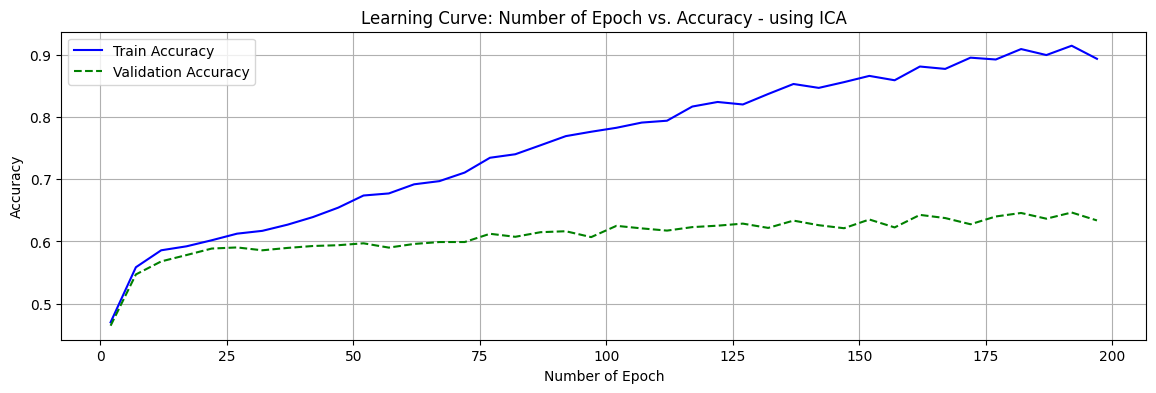

In [114]:
# LEARNING CURVE - on epochs


# Function to train and evaluate the model
def train_and_evaluate(X, y, num_epochs, lr=0.01, num_layers=2, hidden_units=200, activation='relu', cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=328)
    train_accuracies = []
    val_accuracies = []

    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Convert to torch tensors
        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.long)
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.long)


        # Create the model
        model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_fold)
            loss = criterion(output, y_train_fold)
            loss.backward()
            optimizer.step()

        # Evaluation on training set
        model.eval()
        with torch.no_grad():
            train_output = model(X_train_fold)
            train_pred = train_output.argmax(dim=1, keepdim=True)
            train_accuracy = accuracy_score(y_train_fold, train_pred)
            train_accuracies.append(train_accuracy)

            val_output = model(X_val_fold)
            val_pred = val_output.argmax(dim=1, keepdim=True)
            val_accuracy = accuracy_score(y_val_fold, val_pred)
            val_accuracies.append(val_accuracy)

    return np.mean(train_accuracies), np.mean(val_accuracies)

# Main script
num_epochs = np.arange(2, 200, 5)
train_accuracies = []
val_accuracies = []

X_train_ica = X_train_ica if isinstance(X_train_ica, np.ndarray) else X_train_ica.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# ADD TRAINING TIME
ica_times = []
start_time = time.time()
# print(X_train)
for epoch in num_epochs:
    # print("EPOCH",epoch)

    train_acc, val_acc = train_and_evaluate(X_train_ica, Y_train, epoch)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    ica_times.append(time.time() - start_time)

# Plotting the learning curve
plt.figure(figsize=(14, 4))
plt.plot(num_epochs, train_accuracies, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(num_epochs, val_accuracies, label='Validation Accuracy', color='green', linestyle='--')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Number of Epoch vs. Accuracy - using ICA')
plt.legend()
plt.grid(True)
plt.show()

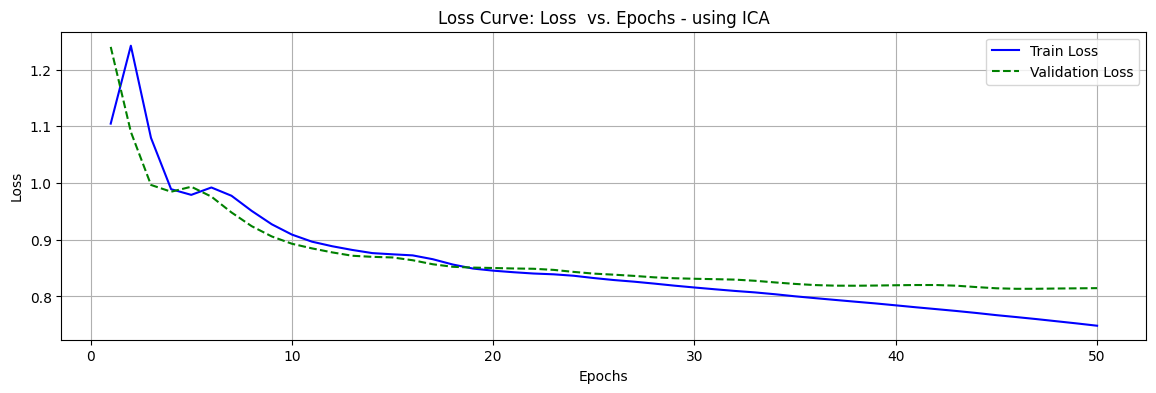

In [115]:
#LOSS CURVE



# Function to train and evaluate the model
def train_and_evaluate(X_train, Y_train, X_Test, Y_test, epochs, lr=0.01, num_layers=2, hidden_units=200, activation='relu'):
    train_losses = []
    val_losses = []

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.long)
    X_Test = torch.tensor(X_Test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.long)


    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, Y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Evaluation on validation set
        model.eval()
        with torch.no_grad():
            val_output = model(X_Test)
            val_loss = criterion(val_output, Y_test)
            val_losses.append(val_loss.item())

    return train_losses, val_losses

# Main script
epochs = 50
train_losses = []
val_losses = []

X_test_ica = X_test_ica if isinstance(X_test_ica, np.ndarray) else X_test_ica.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()
train_losses, val_losses = train_and_evaluate(X_train_ica, Y_train, X_test_ica, Y_test, epochs)

# Plotting the loss curve
plt.figure(figsize=(14, 4))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue', linestyle='-')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='green', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve: Loss  vs. Epochs - using ICA')
plt.legend()
plt.grid(True)
plt.show()



In [116]:
import random
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Function to train the model
def train_model(X_train, y_train, epochs=20, lr=0.003, num_layers=2, hidden_units=200, activation='relu',seed = 390):
    
    set_seed(seed)

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)

    # Determine input size from X_train
    input_size = X_train.shape[1]
    print(X_train.shape[1])
    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    return model


epochs = 20
lr = 0.01
num_layers = 2
hidden_units = 200
activation = 'relu'

Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()

# Train the model
model = train_model(X_train_ica, Y_train, epochs, lr, num_layers, hidden_units, activation)

# Convert the test data to torch tensors
X_test_ica = torch.tensor(X_test_ica, dtype=torch.float32)

# Make predictions on the test data
model.eval()
with torch.no_grad():
    output = model(X_test_ica)
    y_pred = output.argmax(dim=1, keepdim=True).numpy()

# Evaluate the model
print("Classification Report NN with ICA:")
print(classification_report(Y_test, y_pred))
print("Accuracy Score: ", accuracy_score(Y_test, y_pred))

7
Classification Report NN with ICA:
              precision    recall  f1-score   support

           0       0.66      0.57      0.61       304
           1       0.55      0.71      0.62       450
           2       0.61      0.38      0.47       226

    accuracy                           0.59       980
   macro avg       0.61      0.55      0.57       980
weighted avg       0.60      0.59      0.58       980

Accuracy Score:  0.5887755102040816


# Neural Network with Randomized Projection

In [117]:
# Apply Randomized Projection with 4 components
grp = GaussianRandomProjection(n_components=4, random_state=328)
X_train_grp = grp.fit_transform(X_train)

# Only fit Randomized Projection on the training data, and transform the test data without fitting again to prevent data leakage
X_test_grp = grp.transform(X_test)

print(X_train_grp.shape[0])
print(X_test_grp.shape[0])

3918
980


In [118]:
# FINDING OPTIMAL HYPERPARAMETERS 

class Net(nn.Module):
    def __init__(self, num_layers=2, hidden_units=100, activation='relu'):
        super(Net, self).__init__()
        layers = []
        input_size = 4

        # Choose the activation function
        if activation == 'relu':
            activation_function = nn.ReLU()
        elif activation == 'sigmoid':
            activation_function = nn.Sigmoid()
        
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(activation_function)
            input_size = hidden_units
        layers.append(nn.Linear(hidden_units, 3))  # Assuming 10 output classes for classification
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

# Define objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    num_layers = trial.suggest_int('num_layers', 2, 10)
    hidden_units = trial.suggest_int('hidden_units', 10, 256)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid'])

    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Split the data into training and validation sets
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_grp, Y_train, test_size=0.2, random_state=328)
    X_train_split = X_train_split if isinstance(X_train_split, np.ndarray) else X_train_split.to_numpy()
    X_val = X_val if isinstance(X_val, np.ndarray) else X_val.to_numpy()
    y_train_split = y_train_split if isinstance(y_train_split, np.ndarray) else y_train_split.to_numpy()
    y_val = y_val if isinstance(y_val, np.ndarray) else y_val.to_numpy()

    # Convert to torch tensors
    X_train_split = torch.tensor(X_train_split, dtype=torch.float32)
    y_train_split = torch.tensor(y_train_split, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_split)
        loss = criterion(output, y_train_split)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_pred = val_output.argmax(dim=1, keepdim=True)
        accuracy = accuracy_score(y_val, val_pred)

    return accuracy


# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best parameters found: ", study.best_params)
print("Best cross-validation accuracy: {:.2f}".format(study.best_value))

# Use the best model parameters
best_params = study.best_params
best_model = Net(num_layers=best_params['num_layers'], hidden_units=best_params['hidden_units'], activation=best_params['activation'])
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])

print("X Shape",X_train.shape)
print("Y Shape",Y_train.shape)


[I 2024-07-16 17:23:19,700] A new study created in memory with name: no-name-67eeeb38-8e08-457b-8342-22ff8686ca92
[I 2024-07-16 17:23:19,779] Trial 0 finished with value: 0.3380102040816326 and parameters: {'lr': 0.00010947189142115614, 'num_layers': 3, 'hidden_units': 66, 'activation': 'relu'}. Best is trial 0 with value: 0.3380102040816326.
[I 2024-07-16 17:23:21,646] Trial 1 finished with value: 0.3380102040816326 and parameters: {'lr': 0.05752782638381977, 'num_layers': 7, 'hidden_units': 212, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.3380102040816326.
[I 2024-07-16 17:23:21,787] Trial 2 finished with value: 0.4413265306122449 and parameters: {'lr': 0.00026527969226034187, 'num_layers': 5, 'hidden_units': 86, 'activation': 'relu'}. Best is trial 2 with value: 0.4413265306122449.
[I 2024-07-16 17:23:21,962] Trial 3 finished with value: 0.461734693877551 and parameters: {'lr': 0.0018573039040007398, 'num_layers': 7, 'hidden_units': 83, 'activation': 'relu'}. Best is tri

Best parameters found:  {'lr': 0.006706319145403658, 'num_layers': 3, 'hidden_units': 179, 'activation': 'relu'}
Best cross-validation accuracy: 0.51
X Shape (3918, 11)
Y Shape (3918,)


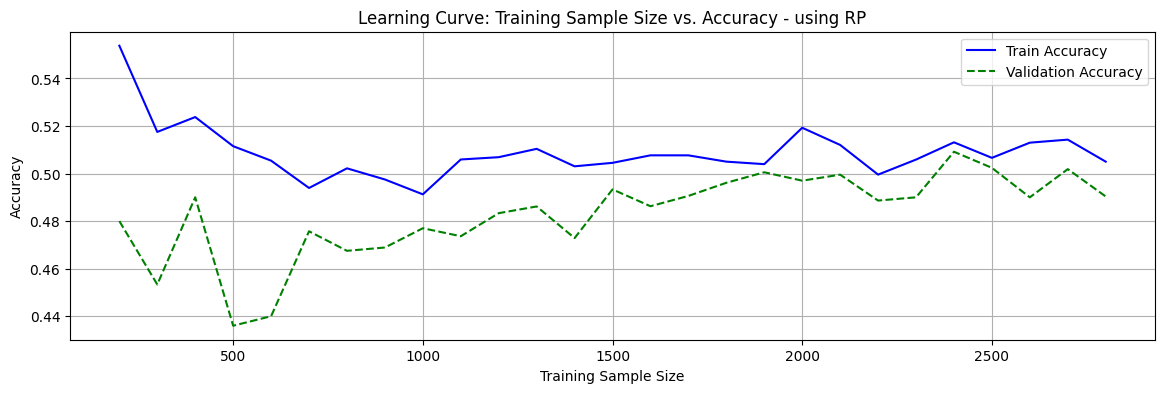

In [119]:
# LEARNING CURVE - on sample size


# Function to train and evaluate the model
def train_and_evaluate(X, y, train_size, lr=0.001, num_layers=2, hidden_units=200, activation='relu', cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=328)
    train_accuracies = []
    val_accuracies = []
    X_sample = X[:train_size]
    Y_sample = y[:train_size]
    for train_index, val_index in skf.split(X_sample, Y_sample):
        X_train_fold, X_val_fold = X_sample[train_index], X_sample[val_index]
        y_train_fold, y_val_fold = Y_sample[train_index], Y_sample[val_index]

        # Convert to torch tensors
        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.long)
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.long)


        # Create the model
        model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_fold)
            loss = criterion(output, y_train_fold)
            loss.backward()
            optimizer.step()

        # Evaluation on training set
        model.eval()
        with torch.no_grad():
            train_output = model(X_train_fold)
            train_pred = train_output.argmax(dim=1, keepdim=True)
            train_accuracy = accuracy_score(y_train_fold, train_pred)
            train_accuracies.append(train_accuracy)

            val_output = model(X_val_fold)
            val_pred = val_output.argmax(dim=1, keepdim=True)
            val_accuracy = accuracy_score(y_val_fold, val_pred)
            val_accuracies.append(val_accuracy)

    return np.mean(train_accuracies), np.mean(val_accuracies)

# Main script
train_sizes = np.arange(200, 2900, 100)
train_accuracies = []
val_accuracies = []

X_train_grp = X_train_grp if isinstance(X_train_grp, np.ndarray) else X_train_grp.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# print(X_train)
for train_size in train_sizes:
    train_acc, val_acc = train_and_evaluate(X_train_grp, Y_train, train_size=train_size)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Plotting the learning curve
plt.figure(figsize=(14, 4))
plt.plot(train_sizes, train_accuracies, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(train_sizes, val_accuracies, label='Validation Accuracy', color='green', linestyle='--')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Training Sample Size vs. Accuracy - using RP')
plt.legend()
plt.grid(True)
plt.show()

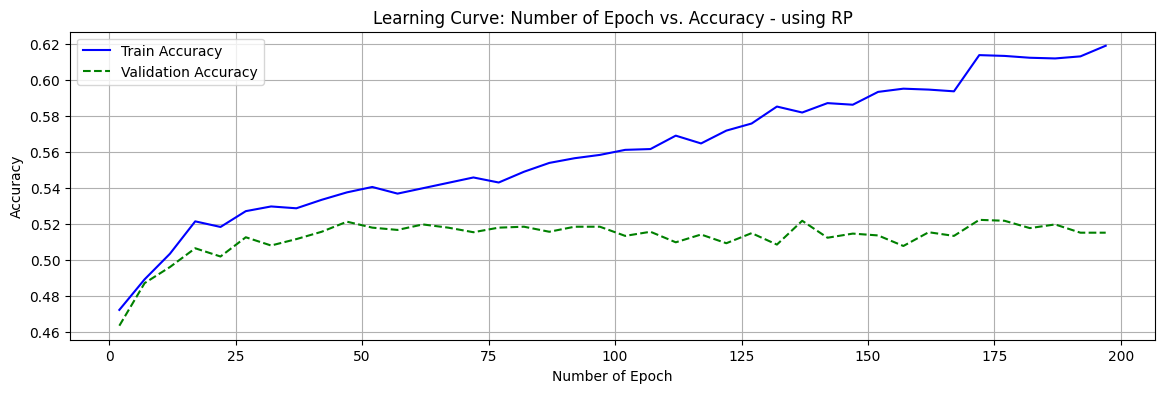

In [120]:
# LEARNING CURVE - on epochs


# Function to train and evaluate the model
def train_and_evaluate(X, y, num_epochs, lr=0.001, num_layers=2, hidden_units=200, activation='relu', cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=328)
    train_accuracies = []
    val_accuracies = []

    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Convert to torch tensors
        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.long)
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.long)


        # Create the model
        model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_fold)
            loss = criterion(output, y_train_fold)
            loss.backward()
            optimizer.step()

        # Evaluation on training set
        model.eval()
        with torch.no_grad():
            train_output = model(X_train_fold)
            train_pred = train_output.argmax(dim=1, keepdim=True)
            train_accuracy = accuracy_score(y_train_fold, train_pred)
            train_accuracies.append(train_accuracy)

            val_output = model(X_val_fold)
            val_pred = val_output.argmax(dim=1, keepdim=True)
            val_accuracy = accuracy_score(y_val_fold, val_pred)
            val_accuracies.append(val_accuracy)

    return np.mean(train_accuracies), np.mean(val_accuracies)

# Main script
num_epochs = np.arange(2, 200, 5)
train_accuracies = []
val_accuracies = []

X_train_grp = X_train_grp if isinstance(X_train_grp, np.ndarray) else X_train_grp.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# ADD training time
grp_times = []
start_time = time.time()

# print(X_train)
for epoch in num_epochs:

    # print("EPOCH",epoch)
    train_acc, val_acc = train_and_evaluate(X_train_grp, Y_train, epoch)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    grp_times.append(time.time() - start_time)

# Plotting the learning curve
plt.figure(figsize=(14, 4))
plt.plot(num_epochs, train_accuracies, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(num_epochs, val_accuracies, label='Validation Accuracy', color='green', linestyle='--')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Number of Epoch vs. Accuracy - using RP')
plt.legend()
plt.grid(True)
plt.show()

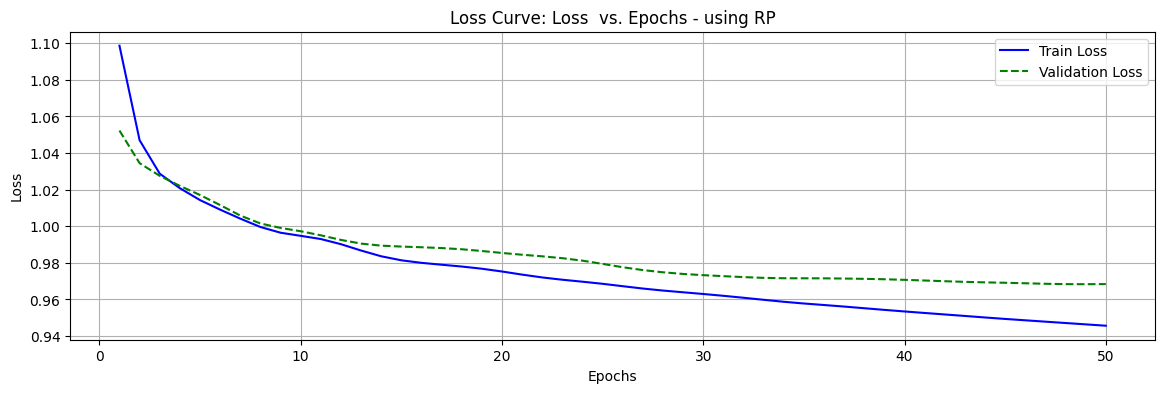

In [121]:
#LOSS CURVE



# Function to train and evaluate the model
def train_and_evaluate(X_train, Y_train, X_Test, Y_test, epochs, lr=0.001, num_layers=2, hidden_units=200, activation='relu'):
    train_losses = []
    val_losses = []

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.long)
    X_Test = torch.tensor(X_Test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.long)


    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, Y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Evaluation on validation set
        model.eval()
        with torch.no_grad():
            val_output = model(X_Test)
            val_loss = criterion(val_output, Y_test)
            val_losses.append(val_loss.item())

    return train_losses, val_losses

# Main script
epochs = 50
train_losses = []
val_losses = []

X_test_grp = X_test_grp if isinstance(X_test_grp, np.ndarray) else X_test_grp.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()
train_losses, val_losses = train_and_evaluate(X_train_grp, Y_train, X_test_grp, Y_test, epochs)

# Plotting the loss curve
plt.figure(figsize=(14, 4))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue', linestyle='-')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='green', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve: Loss  vs. Epochs - using RP')
plt.legend()
plt.grid(True)
plt.show()



In [122]:
import random
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Function to train the model
def train_model(X_train, y_train, epochs=20, lr=0.003, num_layers=2, hidden_units=200, activation='relu',seed = 390):
    
    set_seed(seed)

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)

    # Determine input size from X_train
    input_size = X_train.shape[1]
    print(X_train.shape[1])
    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    return model


epochs = 20
lr = 0.001
num_layers = 2
hidden_units = 200
activation = 'relu'

Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()

# Train the model
model = train_model(X_train_grp, Y_train, epochs, lr, num_layers, hidden_units, activation)

# Convert the test data to torch tensors
X_test_grp = torch.tensor(X_test_grp, dtype=torch.float32)

# Make predictions on the test data
model.eval()
with torch.no_grad():
    output = model(X_test_grp)
    y_pred = output.argmax(dim=1, keepdim=True).numpy()

# Evaluate the model
print("Classification Report NN with RP:")
print(classification_report(Y_test, y_pred))
print("Accuracy Score: ", accuracy_score(Y_test, y_pred))

4
Classification Report NN with RP:
              precision    recall  f1-score   support

           0       0.53      0.45      0.49       304
           1       0.49      0.76      0.60       450
           2       0.59      0.07      0.13       226

    accuracy                           0.51       980
   macro avg       0.54      0.43      0.40       980
weighted avg       0.53      0.51      0.45       980

Accuracy Score:  0.5051020408163265


# Part 5A: Neural Network on data with Kmean Clustering

In [123]:
# Apply KMeans with 6 clusters
kmeans = KMeans(n_clusters=6, random_state=328)
X_train_clusters = kmeans.fit_predict(X_train)

# Apply the same clustering to the test data
X_test_clusters = kmeans.predict(X_test)
X_train_clusters

array([1, 1, 1, ..., 2, 1, 1])

In [124]:
# Add the cluster feature to the training and test data
X_train_with_clusters = np.hstack((X_train, X_train_clusters.reshape(-1, 1)))
X_test_with_clusters = np.hstack((X_test, X_test_clusters.reshape(-1, 1)))

In [125]:
# FINDING OPTIMAL HYPERPARAMETERS 

class Net(nn.Module):
    def __init__(self, num_layers=2, hidden_units=100, activation='relu'):
        super(Net, self).__init__()
        layers = []
        input_size = 12

        # Choose the activation function
        if activation == 'relu':
            activation_function = nn.ReLU()
        elif activation == 'sigmoid':
            activation_function = nn.Sigmoid()
        
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(activation_function)
            input_size = hidden_units
        layers.append(nn.Linear(hidden_units, 3))  # Assuming 10 output classes for classification
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

# Define objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    hidden_units = trial.suggest_int('hidden_units', 10, 256)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid'])

    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Split the data into training and validation sets
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_with_clusters, Y_train, test_size=0.2, random_state=328)
    X_train_split = X_train_split if isinstance(X_train_split, np.ndarray) else X_train_split.to_numpy()
    X_val = X_val if isinstance(X_val, np.ndarray) else X_val.to_numpy()
    y_train_split = y_train_split if isinstance(y_train_split, np.ndarray) else y_train_split.to_numpy()
    y_val = y_val if isinstance(y_val, np.ndarray) else y_val.to_numpy()

    # Convert to torch tensors
    X_train_split = torch.tensor(X_train_split, dtype=torch.float32)
    y_train_split = torch.tensor(y_train_split, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    # Training loop
    num_epochs = 15
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_split)
        loss = criterion(output, y_train_split)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_pred = val_output.argmax(dim=1, keepdim=True)
        accuracy = accuracy_score(y_val, val_pred)

    return accuracy


# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best parameters found: ", study.best_params)
print("Best cross-validation accuracy: {:.2f}".format(study.best_value))

# Use the best model parameters
best_params = study.best_params
best_model = Net(num_layers=best_params['num_layers'], hidden_units=best_params['hidden_units'], activation=best_params['activation'])
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])

print("X Shape",X_train.shape)
print("Y Shape",Y_train.shape)



[I 2024-07-16 17:26:08,150] A new study created in memory with name: no-name-2eb9c4dd-475f-4e15-a9cf-a66fd852f2cf
[I 2024-07-16 17:26:08,234] Trial 0 finished with value: 0.4413265306122449 and parameters: {'lr': 0.0122350110491584, 'num_layers': 5, 'hidden_units': 43, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.4413265306122449.
[I 2024-07-16 17:26:08,357] Trial 1 finished with value: 0.5573979591836735 and parameters: {'lr': 0.005752896173517997, 'num_layers': 3, 'hidden_units': 151, 'activation': 'relu'}. Best is trial 1 with value: 0.5573979591836735.
[I 2024-07-16 17:26:08,489] Trial 2 finished with value: 0.4451530612244898 and parameters: {'lr': 0.0007389201374718995, 'num_layers': 2, 'hidden_units': 242, 'activation': 'sigmoid'}. Best is trial 1 with value: 0.5573979591836735.
[I 2024-07-16 17:26:08,657] Trial 3 finished with value: 0.4413265306122449 and parameters: {'lr': 0.0005498153178296956, 'num_layers': 5, 'hidden_units': 123, 'activation': 'relu'}. Best is t

Best parameters found:  {'lr': 0.02512056760023046, 'num_layers': 3, 'hidden_units': 37, 'activation': 'relu'}
Best cross-validation accuracy: 0.59
X Shape (3918, 11)
Y Shape (3918,)


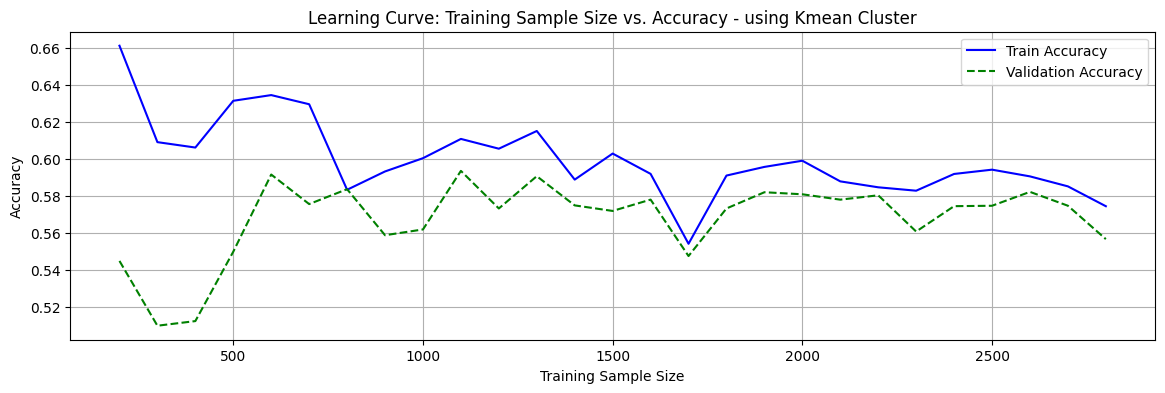

In [126]:
# LEARNING CURVE - on sample size


# Function to train and evaluate the model
def train_and_evaluate(X, y, train_size, lr=0.01, num_layers=4, hidden_units=200, activation='relu', cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=328)
    train_accuracies = []
    val_accuracies = []
    X_sample = X[:train_size]
    Y_sample = y[:train_size]
    for train_index, val_index in skf.split(X_sample, Y_sample):
        X_train_fold, X_val_fold = X_sample[train_index], X_sample[val_index]
        y_train_fold, y_val_fold = Y_sample[train_index], Y_sample[val_index]

        # Convert to torch tensors
        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.long)
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.long)


        # Create the model
        model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_fold)
            loss = criterion(output, y_train_fold)
            loss.backward()
            optimizer.step()

        # Evaluation on training set
        model.eval()
        with torch.no_grad():
            train_output = model(X_train_fold)
            train_pred = train_output.argmax(dim=1, keepdim=True)
            train_accuracy = accuracy_score(y_train_fold, train_pred)
            train_accuracies.append(train_accuracy)

            val_output = model(X_val_fold)
            val_pred = val_output.argmax(dim=1, keepdim=True)
            val_accuracy = accuracy_score(y_val_fold, val_pred)
            val_accuracies.append(val_accuracy)

    return np.mean(train_accuracies), np.mean(val_accuracies)

# Main script
train_sizes = np.arange(200, 2900, 100)
train_accuracies = []
val_accuracies = []

X_train_with_clusters = X_train_with_clusters if isinstance(X_train_with_clusters, np.ndarray) else X_train_with_clusters.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# print(X_train)
for train_size in train_sizes:
    train_acc, val_acc = train_and_evaluate(X_train_with_clusters, Y_train, train_size=train_size)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Plotting the learning curve
plt.figure(figsize=(14, 4))
plt.plot(train_sizes, train_accuracies, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(train_sizes, val_accuracies, label='Validation Accuracy', color='green', linestyle='--')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Training Sample Size vs. Accuracy - using Kmean Cluster')
plt.legend()
plt.grid(True)
plt.show()

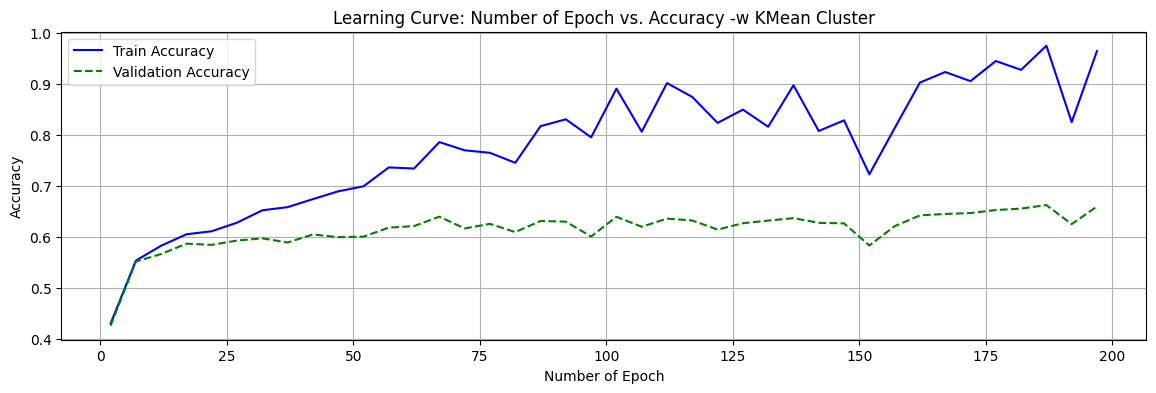

In [127]:
# LEARNING CURVE - on epochs


# Function to train and evaluate the model
def train_and_evaluate(X, y, num_epochs, lr=0.01, num_layers=4, hidden_units=200, activation='relu', cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=328)
    train_accuracies = []
    val_accuracies = []

    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Convert to torch tensors
        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.long)
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.long)


        # Create the model
        model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_fold)
            loss = criterion(output, y_train_fold)
            loss.backward()
            optimizer.step()

        # Evaluation on training set
        model.eval()
        with torch.no_grad():
            train_output = model(X_train_fold)
            train_pred = train_output.argmax(dim=1, keepdim=True)
            train_accuracy = accuracy_score(y_train_fold, train_pred)
            train_accuracies.append(train_accuracy)

            val_output = model(X_val_fold)
            val_pred = val_output.argmax(dim=1, keepdim=True)
            val_accuracy = accuracy_score(y_val_fold, val_pred)
            val_accuracies.append(val_accuracy)

    return np.mean(train_accuracies), np.mean(val_accuracies)

# Main script
num_epochs = np.arange(2, 200, 5)
train_accuracies = []
val_accuracies = []

X_train_with_clusters = X_train_with_clusters if isinstance(X_train_with_clusters, np.ndarray) else X_train_with_clusters.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# add train time
kmean_times = []
start_time = time.time()

# print(X_train)
for epoch in num_epochs:

    # print("EPOCH",epoch)
    train_acc, val_acc = train_and_evaluate(X_train_with_clusters, Y_train, epoch)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    kmean_times.append(time.time() - start_time)

# Plotting the learning curve
plt.figure(figsize=(14, 4))
plt.plot(num_epochs, train_accuracies, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(num_epochs, val_accuracies, label='Validation Accuracy', color='green', linestyle='--')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Number of Epoch vs. Accuracy -w KMean Cluster')
plt.legend()
plt.grid(True)
plt.show()

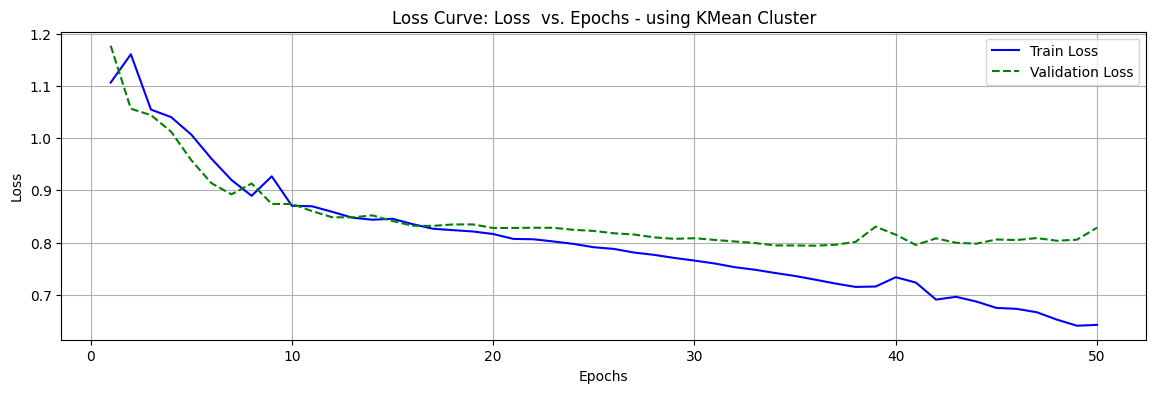

In [128]:
#LOSS CURVE



# Function to train and evaluate the model
def train_and_evaluate(X_train, Y_train, X_Test, Y_test, epochs, lr=0.01, num_layers=4, hidden_units=200, activation='relu'):
    train_losses = []
    val_losses = []

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.long)
    X_Test = torch.tensor(X_Test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.long)


    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, Y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Evaluation on validation set
        model.eval()
        with torch.no_grad():
            val_output = model(X_Test)
            val_loss = criterion(val_output, Y_test)
            val_losses.append(val_loss.item())

    return train_losses, val_losses

# Main script
epochs = 50
train_losses = []
val_losses = []

X_test_with_clusters = X_test_with_clusters if isinstance(X_test_with_clusters, np.ndarray) else X_test_with_clusters.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()
train_losses, val_losses = train_and_evaluate(X_train_with_clusters, Y_train, X_test_with_clusters, Y_test, epochs)

# Plotting the loss curve
plt.figure(figsize=(14, 4))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue', linestyle='-')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='green', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve: Loss  vs. Epochs - using KMean Cluster')
plt.legend()
plt.grid(True)
plt.show()



In [129]:
import random
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Function to train the model
def train_model(X_train, y_train, epochs=20, lr=0.003, num_layers=2, hidden_units=200, activation='relu',seed = 390):
    
    set_seed(seed)

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)

    # Determine input size from X_train
    input_size = X_train.shape[1]
    print(X_train.shape[1])
    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    return model


epochs = 20
lr = 0.01
num_layers = 4
hidden_units = 200
activation = 'relu'

Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()

# Train the model
model = train_model(X_train_with_clusters, Y_train, epochs, lr, num_layers, hidden_units, activation)

# Convert the test data to torch tensors
X_test_with_clusters = torch.tensor(X_test_with_clusters, dtype=torch.float32)

# Make predictions on the test data
model.eval()
with torch.no_grad():
    output = model(X_test_with_clusters)
    y_pred = output.argmax(dim=1, keepdim=True).numpy()

# Evaluate the model
print("Classification Report NN with KMean CLuster:")
print(classification_report(Y_test, y_pred))
print("Accuracy Score: ", accuracy_score(Y_test, y_pred))

12
Classification Report NN with KMean CLuster:
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       304
           1       0.55      0.70      0.62       450
           2       0.63      0.37      0.46       226

    accuracy                           0.60       980
   macro avg       0.62      0.56      0.57       980
weighted avg       0.61      0.60      0.59       980

Accuracy Score:  0.5959183673469388


# Part 5B: Neural Network on dataset with EM Cluster

In [130]:
# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=328)
X_train_clusters = gmm.fit_predict(X_train)

X_test_clusters = gmm.predict(X_test)

In [131]:
# Add the cluster feature to the training and test data
X_train_with_clusters = np.hstack((X_train, X_train_clusters.reshape(-1, 1)))
X_test_with_clusters = np.hstack((X_test, X_test_clusters.reshape(-1, 1)))

In [132]:
# FINDING OPTIMAL HYPERPARAMETERS 

class Net(nn.Module):
    def __init__(self, num_layers=2, hidden_units=100, activation='relu'):
        super(Net, self).__init__()
        layers = []
        input_size = 12

        # Choose the activation function
        if activation == 'relu':
            activation_function = nn.ReLU()
        elif activation == 'sigmoid':
            activation_function = nn.Sigmoid()
        
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(activation_function)
            input_size = hidden_units
        layers.append(nn.Linear(hidden_units, 3))  # Assuming 10 output classes for classification
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

# Define objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    hidden_units = trial.suggest_int('hidden_units', 10, 256)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid'])

    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Split the data into training and validation sets
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_with_clusters, Y_train, test_size=0.2, random_state=328)
    X_train_split = X_train_split if isinstance(X_train_split, np.ndarray) else X_train_split.to_numpy()
    X_val = X_val if isinstance(X_val, np.ndarray) else X_val.to_numpy()
    y_train_split = y_train_split if isinstance(y_train_split, np.ndarray) else y_train_split.to_numpy()
    y_val = y_val if isinstance(y_val, np.ndarray) else y_val.to_numpy()

    # Convert to torch tensors
    X_train_split = torch.tensor(X_train_split, dtype=torch.float32)
    y_train_split = torch.tensor(y_train_split, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    # Training loop
    num_epochs = 15
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_split)
        loss = criterion(output, y_train_split)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_pred = val_output.argmax(dim=1, keepdim=True)
        accuracy = accuracy_score(y_val, val_pred)

    return accuracy


# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best parameters found: ", study.best_params)
print("Best cross-validation accuracy: {:.2f}".format(study.best_value))

# Use the best model parameters
best_params = study.best_params
best_model = Net(num_layers=best_params['num_layers'], hidden_units=best_params['hidden_units'], activation=best_params['activation'])
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])

print("X Shape",X_train.shape)
print("Y Shape",Y_train.shape)



[I 2024-07-16 17:30:26,664] A new study created in memory with name: no-name-22232dc3-609e-4ccc-a845-42db77fbf52b
[I 2024-07-16 17:30:26,805] Trial 0 finished with value: 0.4872448979591837 and parameters: {'lr': 0.00016945557882682157, 'num_layers': 3, 'hidden_units': 187, 'activation': 'relu'}. Best is trial 0 with value: 0.4872448979591837.
[I 2024-07-16 17:30:26,890] Trial 1 finished with value: 0.4413265306122449 and parameters: {'lr': 0.0012432437352603133, 'num_layers': 5, 'hidden_units': 59, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.4872448979591837.
[I 2024-07-16 17:30:27,015] Trial 2 finished with value: 0.5676020408163265 and parameters: {'lr': 0.019875509693184176, 'num_layers': 3, 'hidden_units': 188, 'activation': 'relu'}. Best is trial 2 with value: 0.5676020408163265.
[I 2024-07-16 17:30:27,298] Trial 3 finished with value: 0.4413265306122449 and parameters: {'lr': 0.017042136175004694, 'num_layers': 4, 'hidden_units': 248, 'activation': 'sigmoid'}. Best i

Best parameters found:  {'lr': 0.01085766325725065, 'num_layers': 3, 'hidden_units': 154, 'activation': 'relu'}
Best cross-validation accuracy: 0.58
X Shape (3918, 11)
Y Shape (3918,)


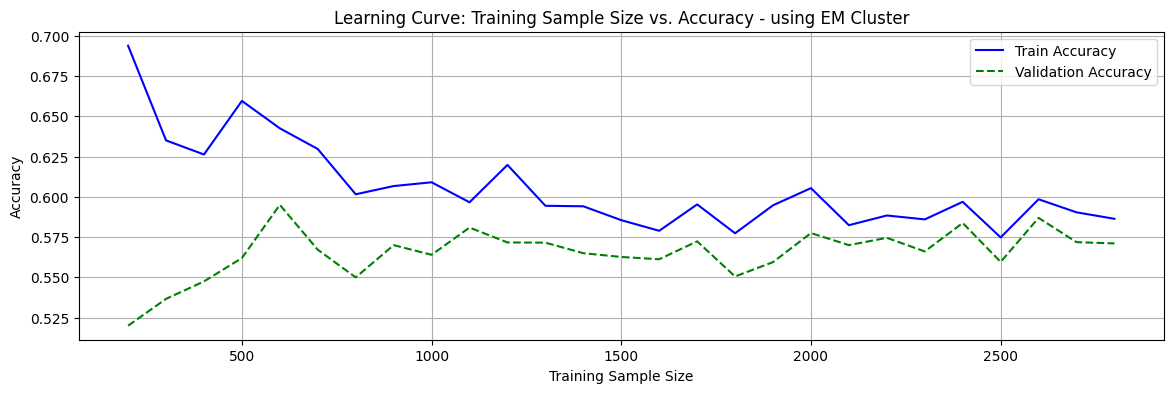

In [133]:
# LEARNING CURVE - on sample size


# Function to train and evaluate the model
def train_and_evaluate(X, y, train_size, lr=0.01, num_layers=2, hidden_units=200, activation='relu', cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=328)
    train_accuracies = []
    val_accuracies = []
    X_sample = X[:train_size]
    Y_sample = y[:train_size]
    for train_index, val_index in skf.split(X_sample, Y_sample):
        X_train_fold, X_val_fold = X_sample[train_index], X_sample[val_index]
        y_train_fold, y_val_fold = Y_sample[train_index], Y_sample[val_index]

        # Convert to torch tensors
        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.long)
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.long)


        # Create the model
        model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        num_epochs = 10
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_fold)
            loss = criterion(output, y_train_fold)
            loss.backward()
            optimizer.step()

        # Evaluation on training set
        model.eval()
        with torch.no_grad():
            train_output = model(X_train_fold)
            train_pred = train_output.argmax(dim=1, keepdim=True)
            train_accuracy = accuracy_score(y_train_fold, train_pred)
            train_accuracies.append(train_accuracy)

            val_output = model(X_val_fold)
            val_pred = val_output.argmax(dim=1, keepdim=True)
            val_accuracy = accuracy_score(y_val_fold, val_pred)
            val_accuracies.append(val_accuracy)

    return np.mean(train_accuracies), np.mean(val_accuracies)

# Main script
train_sizes = np.arange(200, 2900, 100)
train_accuracies = []
val_accuracies = []

X_train_with_clusters = X_train_with_clusters if isinstance(X_train_with_clusters, np.ndarray) else X_train_with_clusters.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# print(X_train)
for train_size in train_sizes:
    train_acc, val_acc = train_and_evaluate(X_train_with_clusters, Y_train, train_size=train_size)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Plotting the learning curve
plt.figure(figsize=(14, 4))
plt.plot(train_sizes, train_accuracies, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(train_sizes, val_accuracies, label='Validation Accuracy', color='green', linestyle='--')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Training Sample Size vs. Accuracy - using EM Cluster')
plt.legend()
plt.grid(True)
plt.show()

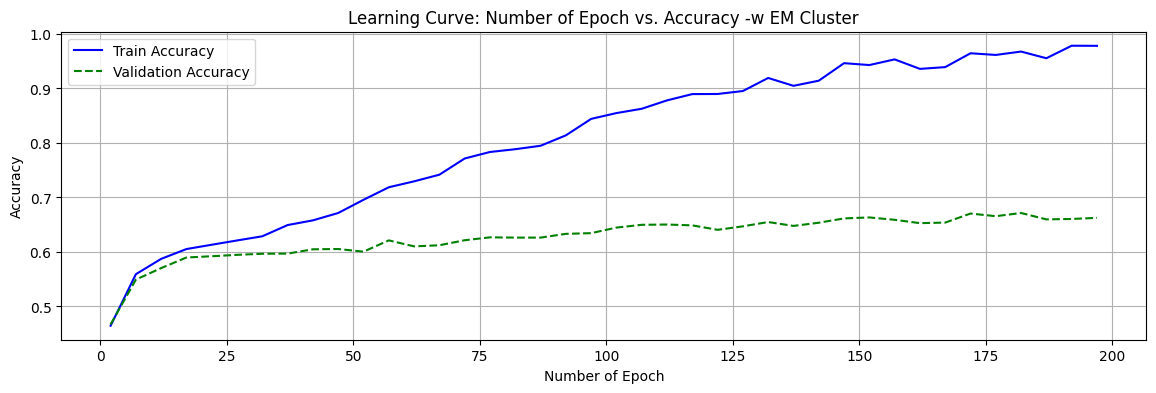

In [134]:
# LEARNING CURVE - on epochs


# Function to train and evaluate the model
def train_and_evaluate(X, y, num_epochs, lr=0.01, num_layers=2, hidden_units=200, activation='relu', cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=328)
    train_accuracies = []
    val_accuracies = []

    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Convert to torch tensors
        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.long)
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.long)


        # Create the model
        model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_fold)
            loss = criterion(output, y_train_fold)
            loss.backward()
            optimizer.step()

        # Evaluation on training set
        model.eval()
        with torch.no_grad():
            train_output = model(X_train_fold)
            train_pred = train_output.argmax(dim=1, keepdim=True)
            train_accuracy = accuracy_score(y_train_fold, train_pred)
            train_accuracies.append(train_accuracy)

            val_output = model(X_val_fold)
            val_pred = val_output.argmax(dim=1, keepdim=True)
            val_accuracy = accuracy_score(y_val_fold, val_pred)
            val_accuracies.append(val_accuracy)

    return np.mean(train_accuracies), np.mean(val_accuracies)

# Main script
num_epochs = np.arange(2, 200, 5)
train_accuracies = []
val_accuracies = []

X_train_with_clusters = X_train_with_clusters if isinstance(X_train_with_clusters, np.ndarray) else X_train_with_clusters.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

#add train time
em_times = []
start_time = time.time()

# print(X_train)
for epoch in num_epochs:

    # print("EPOCH",epoch)
    train_acc, val_acc = train_and_evaluate(X_train_with_clusters, Y_train, epoch)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    em_times.append(time.time() - start_time)

# Plotting the learning curve
plt.figure(figsize=(14, 4))
plt.plot(num_epochs, train_accuracies, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(num_epochs, val_accuracies, label='Validation Accuracy', color='green', linestyle='--')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Number of Epoch vs. Accuracy -w EM Cluster')
plt.legend()
plt.grid(True)
plt.show()

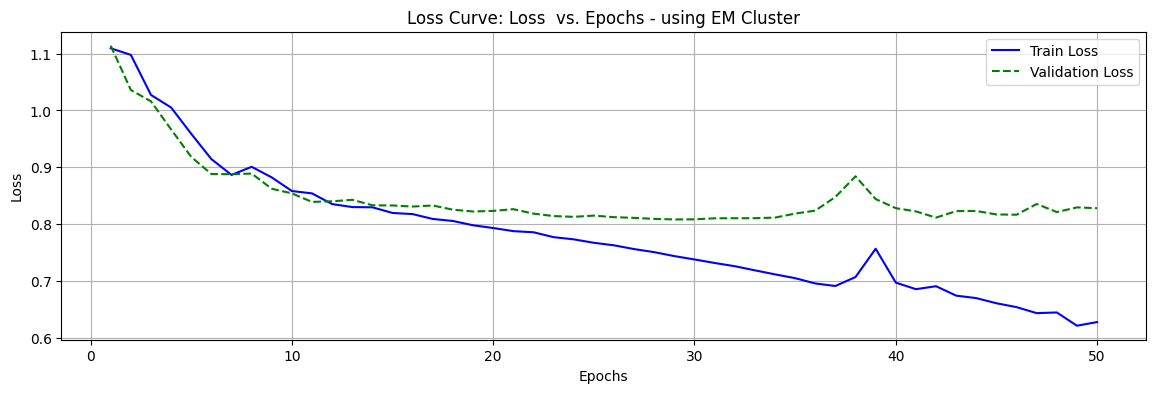

In [135]:
#LOSS CURVE



# Function to train and evaluate the model
def train_and_evaluate(X_train, Y_train, X_Test, Y_test, epochs, lr=0.01, num_layers=4, hidden_units=200, activation='relu'):
    train_losses = []
    val_losses = []

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.long)
    X_Test = torch.tensor(X_Test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.long)


    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, Y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Evaluation on validation set
        model.eval()
        with torch.no_grad():
            val_output = model(X_Test)
            val_loss = criterion(val_output, Y_test)
            val_losses.append(val_loss.item())

    return train_losses, val_losses

# Main script
epochs = 50
train_losses = []
val_losses = []

X_test_with_clusters = X_test_with_clusters if isinstance(X_test_with_clusters, np.ndarray) else X_test_with_clusters.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()
train_losses, val_losses = train_and_evaluate(X_train_with_clusters, Y_train, X_test_with_clusters, Y_test, epochs)

# Plotting the loss curve
plt.figure(figsize=(14, 4))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue', linestyle='-')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='green', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve: Loss  vs. Epochs - using EM Cluster')
plt.legend()
plt.grid(True)
plt.show()



In [136]:
import random
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Function to train the model
def train_model(X_train, y_train, epochs=20, lr=0.003, num_layers=2, hidden_units=200, activation='relu',seed = 390):
    
    set_seed(seed)

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)

    # Determine input size from X_train
    input_size = X_train.shape[1]
    print(X_train.shape[1])
    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    return model


epochs = 30
lr = 0.01
num_layers = 4
hidden_units = 200
activation = 'relu'

Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()

# Train the model
model = train_model(X_train_with_clusters, Y_train, epochs, lr, num_layers, hidden_units, activation)

# Convert the test data to torch tensors
X_test_with_clusters = torch.tensor(X_test_with_clusters, dtype=torch.float32)

# Make predictions on the test data
model.eval()
with torch.no_grad():
    output = model(X_test_with_clusters)
    y_pred = output.argmax(dim=1, keepdim=True).numpy()

# Evaluate the model
print("Classification Report NN with EM CLuster:")
print(classification_report(Y_test, y_pred))
print("Accuracy Score: ", accuracy_score(Y_test, y_pred))

12
Classification Report NN with EM CLuster:
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       304
           1       0.59      0.56      0.58       450
           2       0.54      0.73      0.62       226

    accuracy                           0.60       980
   macro avg       0.61      0.62      0.60       980
weighted avg       0.61      0.60      0.60       980

Accuracy Score:  0.6


# *** Re do Neural network on original data to find training time

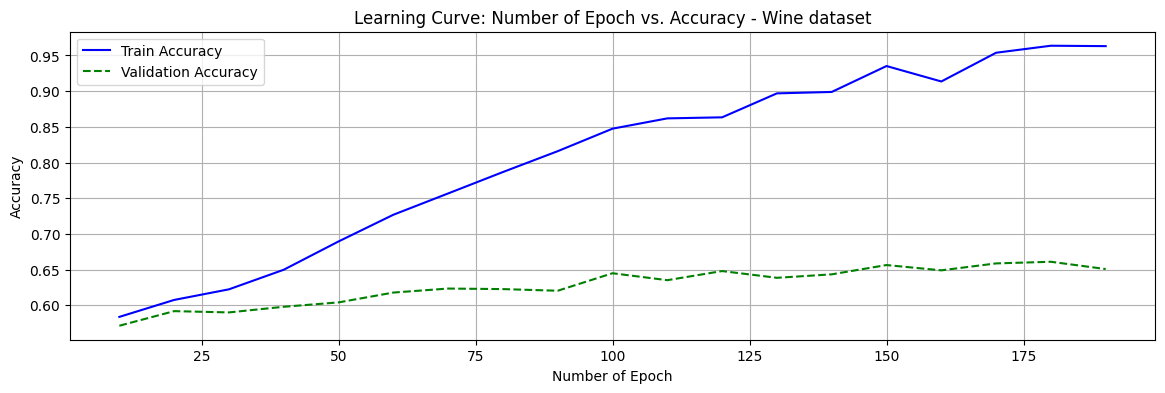

In [149]:
class Net(nn.Module):
    def __init__(self, num_layers=2, hidden_units=200, activation='relu'):
        super(Net, self).__init__()
        layers = []
        input_size = 11

        # Choose the activation function
        if activation == 'relu':
            activation_function = nn.ReLU()
        elif activation == 'sigmoid':
            activation_function = nn.Sigmoid()
        
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(activation_function)
            input_size = hidden_units
        layers.append(nn.Linear(hidden_units, 3))  # Assuming 10 output classes for classification
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)
    
# LEARNING CURVE - on epochs
# Function to train and evaluate the model
def train_and_evaluate(X, y, num_epochs, lr=0.01, num_layers=2, hidden_units=200, activation='relu', cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=328)
    train_accuracies = []
    val_accuracies = []

    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Convert to torch tensors
        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.long)
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.long)


        # Create the model
        model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            output = model(X_train_fold)
            loss = criterion(output, y_train_fold)
            loss.backward()
            optimizer.step()

        # Evaluation on training set
        model.eval()
        with torch.no_grad():
            train_output = model(X_train_fold)
            train_pred = train_output.argmax(dim=1, keepdim=True)
            train_accuracy = accuracy_score(y_train_fold, train_pred)
            train_accuracies.append(train_accuracy)

            val_output = model(X_val_fold)
            val_pred = val_output.argmax(dim=1, keepdim=True)
            val_accuracy = accuracy_score(y_val_fold, val_pred)
            val_accuracies.append(val_accuracy)

    return np.mean(train_accuracies), np.mean(val_accuracies)

# Main script
num_epochs = np.arange(10, 200, 10)
train_accuracies = []
val_accuracies = []

X_train = X_train if isinstance(X_train, np.ndarray) else X_train.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# ADD TRAINING TIME
nn_times = []
start_time = time.time()

# print(X_train)
for epoch in num_epochs:

    # print("EPOCH",epoch)
    train_acc, val_acc = train_and_evaluate(X_train, Y_train, epoch, lr=0.01, num_layers=2, hidden_units=200, activation='relu', cv=5)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    nn_times.append(time.time() - start_time)

# Plotting the learning curve
plt.figure(figsize=(14, 4))
plt.plot(num_epochs, train_accuracies, label='Train Accuracy', color='blue', linestyle='-')
plt.plot(num_epochs, val_accuracies, label='Validation Accuracy', color='green', linestyle='--')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Number of Epoch vs. Accuracy - Wine dataset')
plt.legend()
plt.grid(True)
plt.show()



In [150]:
import random
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Function to train the model
def train_model(X_train, y_train, epochs=20, lr=0.007, num_layers=2, hidden_units=200, activation='relu',seed = 390):
    
    set_seed(seed)

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)

    # Determine input size from X_train
    input_size = X_train.shape[1]
    print(X_train.shape[1])
    # Create the model
    model = Net(num_layers=num_layers, hidden_units=hidden_units, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        # Training loop
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    return model


epochs = 30
lr = 0.01
num_layers = 2
hidden_units = 200
activation = 'relu'

Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()
Y_test = Y_test if isinstance(Y_test, np.ndarray) else Y_test.to_numpy()

# Train the model
model = train_model(X_train, Y_train, epochs, lr, num_layers, hidden_units, activation)

# Convert the test data to torch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)

# Make predictions on the test data
model.eval()
with torch.no_grad():
    output = model(X_test)
    y_pred = output.argmax(dim=1, keepdim=True).numpy()

# Evaluate the model
print("Classification Report NN:")
print(classification_report(Y_test, y_pred))
print("Accuracy Score: ", accuracy_score(Y_test, y_pred))

11
Classification Report NN:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       304
           1       0.59      0.69      0.64       450
           2       0.65      0.42      0.51       226

    accuracy                           0.63       980
   macro avg       0.64      0.60      0.61       980
weighted avg       0.63      0.63      0.62       980

Accuracy Score:  0.6255102040816326


Due to different learning rate affect training time, have to re-run the whole neural network on each experiment with same hyperparameters

In [151]:
# PCA Train time

class Net(nn.Module):
    def __init__(self, num_layers=2, hidden_units=100, activation='relu'):
        super(Net, self).__init__()
        layers = []
        input_size = 8  

        # Choose the activation function
        if activation == 'relu':
            activation_function = nn.ReLU()
        elif activation == 'sigmoid':
            activation_function = nn.Sigmoid()
        
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(activation_function)
            input_size = hidden_units
        layers.append(nn.Linear(hidden_units, 3))  # Assuming 10 output classes for classification
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)


# Main script
num_epochs = np.arange(10, 200, 10)
train_accuracies = []
val_accuracies = []

X_train_pca = X_train_pca if isinstance(X_train_pca, np.ndarray) else X_train_pca.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# ADD TRAIN TIME
pca_times = []
start_time = time.time()

# print(X_train)
for epoch in num_epochs:
    # print("EPOCH",epoch)

    _, _ = train_and_evaluate(X_train_pca, Y_train, epoch, lr=0.01, num_layers=2, hidden_units=200, activation='relu', cv=5)

    pca_times.append(time.time() - start_time)


In [152]:
# ICA train time


class Net(nn.Module):
    def __init__(self, num_layers=2, hidden_units=100, activation='relu'):
        super(Net, self).__init__()
        layers = []
        input_size = 7  

        # Choose the activation function
        if activation == 'relu':
            activation_function = nn.ReLU()
        elif activation == 'sigmoid':
            activation_function = nn.Sigmoid()
        
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(activation_function)
            input_size = hidden_units
        layers.append(nn.Linear(hidden_units, 3))  # Assuming 10 output classes for classification
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)
    


# Main script
num_epochs = np.arange(10, 200, 10)
train_accuracies = []
val_accuracies = []

X_train_ica = X_train_ica if isinstance(X_train_ica, np.ndarray) else X_train_ica.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# ADD TRAINING TIME
ica_times = []
start_time = time.time()
# print(X_train)
for epoch in num_epochs:
    # print("EPOCH",epoch)

    train_acc, val_acc = train_and_evaluate(X_train_ica, Y_train, epoch, lr=0.01, num_layers=2, hidden_units=200, activation='relu', cv=5)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    ica_times.append(time.time() - start_time)



In [153]:
# RP train time
class Net(nn.Module):
    def __init__(self, num_layers=2, hidden_units=100, activation='relu'):
        super(Net, self).__init__()
        layers = []
        input_size = 4  

        # Choose the activation function
        if activation == 'relu':
            activation_function = nn.ReLU()
        elif activation == 'sigmoid':
            activation_function = nn.Sigmoid()
        
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(activation_function)
            input_size = hidden_units
        layers.append(nn.Linear(hidden_units, 3))  # Assuming 10 output classes for classification
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

# Main script
num_epochs = np.arange(10, 200, 10)
train_accuracies = []
val_accuracies = []

X_train_grp = X_train_grp if isinstance(X_train_grp, np.ndarray) else X_train_grp.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# ADD training time
grp_times = []
start_time = time.time()

# print(X_train)
for epoch in num_epochs:

    # print("EPOCH",epoch)
    train_acc, val_acc = train_and_evaluate(X_train_grp, Y_train, epoch, lr=0.01, num_layers=2, hidden_units=200, activation='relu', cv=5)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    grp_times.append(time.time() - start_time)


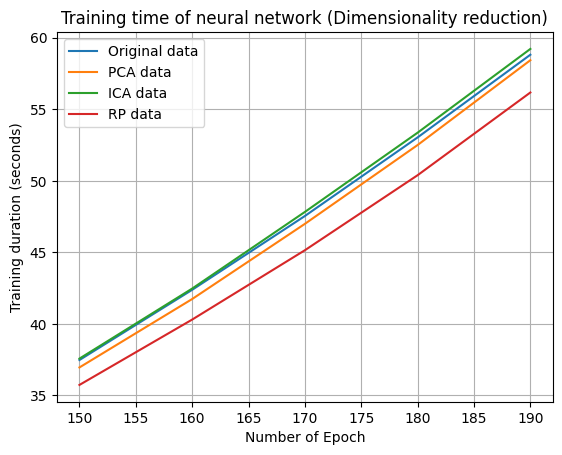

In [154]:

plt.plot(num_epochs[-5:], nn_times[-5:], label='Original data')
plt.plot(num_epochs[-5:], pca_times[-5:], label='PCA data')
plt.plot(num_epochs[-5:], ica_times[-5:], label='ICA data')
plt.plot(num_epochs[-5:], grp_times[-5:], label='RP data')
plt.xlabel('Number of Epoch')
plt.ylabel('Training duration (seconds)')
plt.title('Training time of neural network (Dimensionality reduction)')
plt.legend()
plt.grid(True)
plt.show()

In [155]:
# EM TRAIN TIME
class Net(nn.Module):
    def __init__(self, num_layers=2, hidden_units=100, activation='relu'):
        super(Net, self).__init__()
        layers = []
        input_size = 12  

        # Choose the activation function
        if activation == 'relu':
            activation_function = nn.ReLU()
        elif activation == 'sigmoid':
            activation_function = nn.Sigmoid()
        
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(activation_function)
            input_size = hidden_units
        layers.append(nn.Linear(hidden_units, 3))  # Assuming 10 output classes for classification
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)

# Main script
num_epochs = np.arange(10, 200, 10)
train_accuracies = []
val_accuracies = []

X_train_with_clusters = X_train_with_clusters if isinstance(X_train_with_clusters, np.ndarray) else X_train_with_clusters.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

#add train time
em_times = []
start_time = time.time()

# print(X_train)
for epoch in num_epochs:

    # print("EPOCH",epoch)
    train_acc, val_acc = train_and_evaluate(X_train_with_clusters, Y_train, epoch,lr=0.01, num_layers=2, hidden_units=200, activation='relu', cv=5)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    em_times.append(time.time() - start_time)


In [156]:
# KMEANS TIME

# EM TRAIN TIME
class Net(nn.Module):
    def __init__(self, num_layers=2, hidden_units=100, activation='relu'):
        super(Net, self).__init__()
        layers = []
        input_size = 12  

        # Choose the activation function
        if activation == 'relu':
            activation_function = nn.ReLU()
        elif activation == 'sigmoid':
            activation_function = nn.Sigmoid()
        
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, hidden_units))
            layers.append(activation_function)
            input_size = hidden_units
        layers.append(nn.Linear(hidden_units, 3))  # Assuming 10 output classes for classification
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        return self.net(X)


# Main script
num_epochs = np.arange(10, 200, 10)
train_accuracies = []
val_accuracies = []

X_train_with_clusters = X_train_with_clusters if isinstance(X_train_with_clusters, np.ndarray) else X_train_with_clusters.to_numpy()
Y_train = Y_train if isinstance(Y_train, np.ndarray) else Y_train.to_numpy()

# add train time
kmean_times = []
start_time = time.time()

# print(X_train)
for epoch in num_epochs:

    # print("EPOCH",epoch)
    train_acc, val_acc = train_and_evaluate(X_train_with_clusters, Y_train, epoch, lr=0.01, num_layers=2, hidden_units=200, activation='relu', cv=5)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    kmean_times.append(time.time() - start_time)



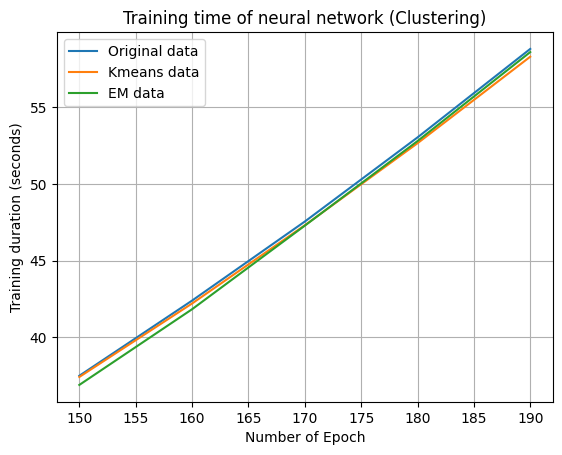

In [157]:

plt.plot(num_epochs[-5:], nn_times[-5:], label='Original data')
plt.plot(num_epochs[-5:], kmean_times[-5:], label='Kmeans data')
plt.plot(num_epochs[-5:], em_times[-5:], label='EM data')
plt.xlabel('Number of Epoch')
plt.ylabel('Training duration (seconds)')
plt.title('Training time of neural network (Clustering)')
plt.legend()
plt.grid(True)
plt.show()

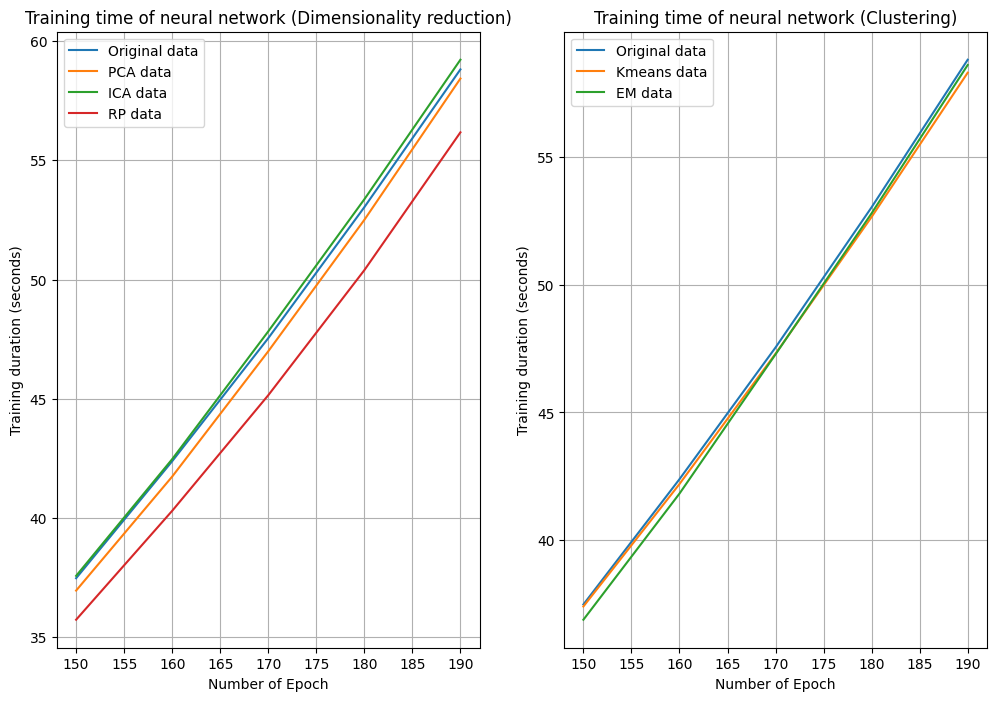

In [158]:
plt.figure(figsize= (12,8))

plt.subplot(1,2,1)
plt.plot(num_epochs[-5:], nn_times[-5:], label='Original data')
plt.plot(num_epochs[-5:], pca_times[-5:], label='PCA data')
plt.plot(num_epochs[-5:], ica_times[-5:], label='ICA data')
plt.plot(num_epochs[-5:], grp_times[-5:], label='RP data')
plt.xlabel('Number of Epoch')
plt.ylabel('Training duration (seconds)')
plt.title('Training time of neural network (Dimensionality reduction)')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(num_epochs[-5:], nn_times[-5:], label='Original data')
plt.plot(num_epochs[-5:], kmean_times[-5:], label='Kmeans data')
plt.plot(num_epochs[-5:], em_times[-5:], label='EM data')
plt.xlabel('Number of Epoch')
plt.ylabel('Training duration (seconds)')
plt.title('Training time of neural network (Clustering)')
plt.legend()
plt.grid(True)
plt.show()